<a href="https://colab.research.google.com/github/srilav/neuralnetwork/blob/main/keras_Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Face Mask Detection using Convolutional Neural Networks

## Learning Objectives

At the end of the miniproject, you will be able to :

* load and extract features of images using ImageDataGenerator

* build the convolutional neural networks

* use the pre-trained models using keras applications

## Introduction

This project uses a Deep Neural Network, more specifically a Convolutional Neural Network, to differentiate between images of people, with masks, without masks and incorrectly placed masks. Manually built and pretrained networks will be used to perform this classification task.

**Face-Mask-Detection-Using-CNN**

* Outbreak of the Coronavirus pandemic has created various changes in the lifestyle of everyone around the world.
* Among these changes, wearing a mask has been very vital to every individual.
* Detection of people who are not wearing masks is a challenge due to the large populations.
* This face mask detection project can be used in schools, hospitals, banks, airports etc as a digitalized scanning tool. 
  - The technique of detecting people’s faces and segregating them into three classes namely the people with masks and people without masks and partial masks is done with the help of image processing and deep learning.
* With the help of this project, a person who is monitoring the face mask status for a particular firm can be seated in a remote area and still monitor efficiently and give instructions accordingly.

![img](https://d2h0cx97tjks2p.cloudfront.net/blogs/wp-content/uploads/sites/2/2020/07/dataset-with-mask-1536x844.png)

## Dataset

The data for this mini-project is collected from various sources including the masked images from internet and general frontal face images considered as without mask. This dataset consists of 5029 train images and 1059 test images with 3 classes `with_mask`, `without_mask` and `partial_mask`

Many people are not correctly wearing their masks due to bad practices, bad behaviors or vulnerability of individuals (e.g., children, old people). For these reasons, several mask wearing campaigns intend to sensitize people about this problem and good practices. In this sense, this work proposes three types of masked face detection dataset; namely, the Correctly Masked Face, the Incorrectly Masked Face and their combination for the global masked face detection. This dataset serves the objective of classifying faces that are: 
  
- Without Mask/ With Mask/ Partial Mask
  
Note that this dataset contains some annotated (artificially generated) masks to augment the 'masked' data category.

## Problem Statement

To build and implement a Convolutional Neural Network model to classify between masked/unmasked/partially masked faces.

### Import Required packages

In [ ]:
import numpy as np
import PIL
from matplotlib import pyplot as plt
import glob, os
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
from PIL import Image
import pathlib
#For Reproducibility
SEEDS = 42
np.random.seed(SEEDS)
tf.random.set_seed(SEEDS)

In [ ]:
print(tf.__version__)

2.7.0


## Data Loading and preprocessing (2 points)

### Analyze the shape of images and distribution of classes

In [ ]:
#Load data
dataset_url ='https://cdn.iisc.talentsprint.com/CDS/MiniProjects/MP2_FaceMask_Dataset.zip'
data_dir= tf.keras.utils.get_file(origin=dataset_url, fname="FaceMask_Dataset",  extract=True)
#data_dir= '/root/.keras/datasets/MP2_FaceMask_Dataset' #If data is in cache
data_path = pathlib.Path(data_dir)
#os.makedirs(mydir, exist_ok=True)
#dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir, image_size=(180, 180), batch_size=64)
train_data_filepath = os.path.dirname(data_path)+'/MP2_FaceMask_Dataset/train'
test_data_filepath = os.path.dirname(data_path)+'/MP2_FaceMask_Dataset/test'

589930496/589920212 [==============================] - 60s 0us/step


In [ ]:
data_dir

'/root/.keras/datasets/FaceMask_Dataset'

In [ ]:
os.path.exists('/root/.keras/datasets/MP2_FaceMask_Dataset')

True

In [ ]:
os.path.exists(os.path.dirname('FaceMask_Dataset'))

False

In [ ]:
os.path.isdir('/root/.keras/datasets/MP2_FaceMask_Dataset')

True

In [ ]:
os.listdir('/root/.keras/datasets/MP2_FaceMask_Dataset')

['train', 'test']

In [ ]:
categories = os.listdir(train_data_filepath)
categories

['without_mask', 'with_mask', 'partial_mask']

In [ ]:
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories,labels))
print(categories)
print(labels)
print(label_dict)

['without_mask', 'with_mask', 'partial_mask']
[0, 1, 2]
{'without_mask': 0, 'with_mask': 1, 'partial_mask': 2}


In [ ]:
def label_extract():
  #image_size = 256
  image_path=[]
  labels = []
  for category in categories:
    category_path = os.path.join(train_data_filepath,category)
    image_names = os.listdir(category_path)
    for image_name in image_names:
      try:
        image_path.append(os.path.join(category_path,image_name))
        labels.append(category)
      except:
        print("Error Loading Image")
  labels = np.array(labels)
  return image_path,labels


image_path,labels=label_extract()

JPEG
RGB
(160, 160)


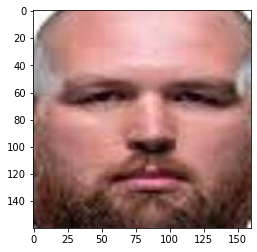

In [ ]:
from PIL import Image
# load the image
image = Image.open(image_path[0])
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)
# display the array of pixels as an image
plt.imshow(image)
plt.show()

[['partial_mask' 'with_mask' 'without_mask']
 ['1294' '1624' '2138']]


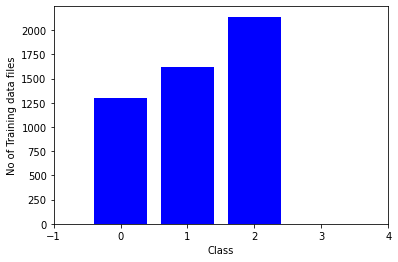

In [ ]:
# Checking for class bias
def check_target_class_bias():
  unique_labels, Label_count = np.unique(labels, return_counts = True)
  print(np.asarray((unique_labels,Label_count)))
  plt.bar( np.arange(3), Label_count, align='center',color='blue' )
  plt.xlabel('Class')
  plt.ylabel('No of Training data files')
  plt.xlim([-1, 4])

  plt.show()

check_target_class_bias()

### Load the images using ImageDataGenerator

There are two main steps involved in creating the generator.
1. Instantiate ImageDataGenerator with required arguments to create an object
2. Use the `flow_from_directory` command depending on how your data is stored on disk. This is the command that will allow you to generate and get access to batches of data on the fly.

Hint: [link](https://keras.io/api/preprocessing/image/)

In [ ]:
train_data_filepath

'/root/.keras/datasets/MP2_FaceMask_Dataset/train'

In [ ]:
TRAINING_DIR='/root/.keras/datasets/MP2_FaceMask_Dataset/train'

In [ ]:
# YOUR CODE HERE
#batch_size = 5031
img_height = 256 #Default
img_width = 256
train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAINING_DIR,
  labels='inferred',
  label_mode= 'categorical',
  class_names=['partial_mask', 'with_mask', 'without_mask'],
  color_mode='rgb',
  seed=123,
  image_size=(img_height, img_width))

Found 5031 files belonging to 3 classes.


In [ ]:
 VALIDATION_DIR ='/root/.keras/datasets/MP2_FaceMask_Dataset/test'
img_height = 256 #Default
img_width = 256
val_ds = tf.keras.utils.image_dataset_from_directory(
  VALIDATION_DIR,
  labels='inferred',
  label_mode= 'categorical',
  class_names=['partial_mask', 'with_mask', 'without_mask'],
  color_mode='rgb',
  seed=123,
  image_size=(img_height, img_width))

Found 1260 files belonging to 3 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['partial_mask', 'with_mask', 'without_mask']


In [ ]:
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32, 3)


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

InvalidArgumentError: ignored

Just because the extension is .jpg does not mean the file is a true jpg image. I suggest you run the code below to see which image may be defective.

In [ ]:
import os
import cv2
def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                index=f.rfind('.')
                ext=f[index+1:].lower()
                if ext not in ext_list:
                    print('file ', f_path, ' has an invalid extension ', ext)
                    bad_ext.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir ='/root/.keras/datasets/MP2_FaceMask_Dataset/train'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  without_mask
processing class directory  with_mask
file  /root/.keras/datasets/MP2_FaceMask_Dataset/train/with_mask/novas (26).webp  has an invalid extension  webp
file  /root/.keras/datasets/MP2_FaceMask_Dataset/train/with_mask/novas (15).webp  has an invalid extension  webp
file  /root/.keras/datasets/MP2_FaceMask_Dataset/train/with_mask/novas (24).webp  has an invalid extension  webp
file  /root/.keras/datasets/MP2_FaceMask_Dataset/train/with_mask/novas (17).webp  has an invalid extension  webp
file  /root/.keras/datasets/MP2_FaceMask_Dataset/train/with_mask/novas (6).webp  has an invalid extension  webp
file  /root/.keras/datasets/MP2_FaceMask_Dataset/train/with_mask/novas (22).webp  has an invalid extension  webp
file  /root/.keras/datasets/MP2_FaceMask_Dataset/train/with_mask/novas (21).webp  has an invalid extension  webp
file  /root/.keras/datasets/MP2_FaceMask_Dataset/train/with_mask/novas (11).webp  has an invalid extension  webp
file  /root/.keras

In [ ]:
bad_ext_list

['/root/.keras/datasets/MP2_FaceMask_Dataset/train/with_mask/novas (26).webp',
 '/root/.keras/datasets/MP2_FaceMask_Dataset/train/with_mask/novas (15).webp',
 '/root/.keras/datasets/MP2_FaceMask_Dataset/train/with_mask/novas (24).webp',
 '/root/.keras/datasets/MP2_FaceMask_Dataset/train/with_mask/novas (17).webp',
 '/root/.keras/datasets/MP2_FaceMask_Dataset/train/with_mask/novas (6).webp',
 '/root/.keras/datasets/MP2_FaceMask_Dataset/train/with_mask/novas (22).webp',
 '/root/.keras/datasets/MP2_FaceMask_Dataset/train/with_mask/novas (21).webp',
 '/root/.keras/datasets/MP2_FaceMask_Dataset/train/with_mask/novas (11).webp',
 '/root/.keras/datasets/MP2_FaceMask_Dataset/train/with_mask/novas (2).webp',
 '/root/.keras/datasets/MP2_FaceMask_Dataset/train/with_mask/novas (18).webp',
 '/root/.keras/datasets/MP2_FaceMask_Dataset/train/with_mask/novas (20).webp',
 '/root/.keras/datasets/MP2_FaceMask_Dataset/train/with_mask/novas (4).webp',
 '/root/.keras/datasets/MP2_FaceMask_Dataset/train/with

Becuase there are few unsupported formats using flow from directory to load

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR ,
        seed=42,
        shuffle=True,
        target_size=(256, 256),
        batch_size=32 ,
        color_mode="rgb",
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        VALIDATION_DIR,
        seed=42,
        shuffle=True,
        target_size=(256, 256),
        batch_size=32,
        color_mode="rgb",
        class_mode='categorical')

Found 5029 images belonging to 3 classes.
Found 1259 images belonging to 3 classes.


### Visualize the sample images of each class using data generator

Hint: plt.subplot

In [ ]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)
images, labels = next(img_gen.flow_from_directory(TRAINING_DIR))
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

Found 5029 images belonging to 3 classes.
float32 (32, 256, 256, 3)
float32 (32, 3)


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

## Build the CNN model using Keras (4 points)



**Convolutional Neural Network:** A neural network in which at least one layer is a convolutional layer. A typical convolutional neural network consists of some combination of the following layers:

* convolutional layers
* pooling layers
* dense layers


**Conv2D**  

Passing an image with input shape of 3-D and to calculate the output: 

 $O = \frac{n - f + 2p}{s} + 1$

**MaxPool** 

The resulting output, when using the "valid" padding option, has a spatial shape (number of rows or columns) of: 

O = `math.floor`$(\frac{input shape - pool size)}{ strides}) + 1$ (when input shape >= pool size)

The resulting output shape when using the "same" padding option is: 

O = `math.floor`$(\frac{input shape - 1}{strides}) + 1$

by default, stride = None, so stride is same as pool size

Task-flow
* Initialize the network of convolution, maxpooling and dense layers
* Define the optimizer and loss functions
* Fit the model and evaluate the model

In [ ]:
def prepare_model():
    model = Sequential()
    model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(256, 256,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
    return model

In [ ]:
model = prepare_model()
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50


InvalidArgumentError: ignored

## Transfer learning (4 points)

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

For eg. Using VGG16, we remove the last layer which takes a probability for each of the 1000 classes in the ImageNet and replaces it with a layer that takes 3 probabilities in our case.

### Use the pre-trained models ([VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16) or [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50))

* Load the pre-trained model
* Fit and evaluate the data

Hint: [How to use pre-trained model](https://towardsdatascience.com/step-by-step-guide-to-using-pretrained-models-in-keras-c9097b647b29)

#### Expected accuracy: More than 90%

Task-flow
* Initialize the network with the weights of Imagenet
* Fine tune the network by modifying fully connected layers.
* Re-train the model with our problem data

In [ ]:
# YOUR CODE HERE

### Capture the live image using the below code cell and predict

In [ ]:
#@title Capture the photo
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  display(Image(filename))
except Exception as err:
  print(str(err))

After executing above cell and capturing the photo, load the captured photo and predict with model.

**Note:** 
* Convert the image to numpy array and resize to the shape which model accept. 
* Extend the dimension (to 4-D shape) of an image, as the model is trained on a batch of inputs.

In [ ]:
features = PIL.Image.open("photo.jpg")
plt.imshow(features);
# YOUR CODE HERE to predict the image

### Instructions for preparing Kaggle competition predictions

Important: Refer the [Kaggle Team Creation Instructions Doc](https://drive.google.com/file/d/1NwUrRFpGuSagueS_BwGNq4upnyagTDxb/view?usp=sharing) 

* Load the image paths from Kaggle testset using `glob`
* Read the Images using `PIL.Image.open` and resize to required shape.
* Get the predictions using trained model and prepare a csv file
  - FC layer of DeepNet model gives output for each class, consider the maximum value among all classes as prediction using `np.argmax`.
* Predictions (csv) file should contain 2 columns as Sample_Submission.csv
  - First column is the img_path which is considered as index
  - Second column is prediction in decoded form (for eg. with_mask, partial_mask, without_mask).



### Report Analysis

- Compare the accuracies for the Pre-trained vs CNN models
- What process was followed to tune the hyperparameters?
- Which model detects the mask/no mask/ partial mask more accurately with the live pictures?
- Discuss the confusion matrix in terms of the misclassifications